# Bayesian optimization

This tutorial is an introduction to the syntax used by the optimizer, as well as the principles of Bayesian optimization in general.

We'll start by minimizing the Styblinski-Tang function in one dimension, which looks like this:

(-5.0, 5.0)

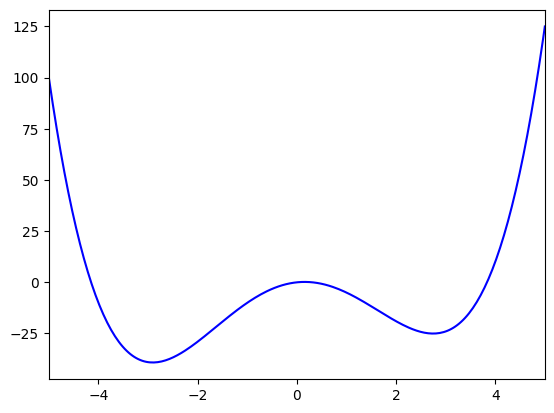

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

from bloptools import test_functions

x = np.linspace(-5, 5, 256)

plt.plot(x, test_functions.styblinski_tang(x), c="b")
plt.xlim(-5, 5)

There are several things that our agent will need. The first ingredient is some degrees of freedom (these are always `ophyd` devices) which the agent will move around to different inputs within each DOF's bounds (the second ingredient). We define these here:

In [2]:
from bloptools import devices

dofs = [
    {"device": devices.DOF(name="x"), "limits": (-5, 5), "kind": "active"},
]

In [3]:
tasks = [
    {"key": "styblinski-tang", "kind": "minimize"},
]


This degree of freedom will move around a variable called `x1`. The agent automatically samples at different inputs, but we often need some post-processing after data collection. In this case, we need to give the agent a way to compute the Styblinski-Tang function. We accomplish this with a digestion function, which always takes `(db, uid)` as an input. For each entry, we compute the function:


In [4]:
def digestion(db, uid):
    products = db[uid].table()

    for index, entry in products.iterrows():
        products.loc[index, "styblinski-tang"] = test_functions.styblinski_tang(entry.x)

    return products

The next ingredient is a task, which gives the agent something to do. We want it to minimize the Styblinski-Tang function, so we make a task that will try to minimize the output of the digestion function called "styblinski-tang".

In [5]:
%run -i ../../../examples/prepare_bluesky.py # prepare the bluesky environment

from bloptools.bayesian import Agent

agent = Agent(
    dofs=dofs,
    tasks=tasks,
    digestion=digestion,
    db=db,
)

RE(agent.initialize("qr", n_init=4))



Transient Scan ID: 1     Time: 2023-08-11 05:55:13
Persistent Unique Scan ID: '85110f9e-1163-4a60-b64f-97f73d930a41'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |          x |
+-----------+------------+------------+
|         1 | 05:55:13.7 |     -1.138 |
|         2 | 05:55:13.7 |      0.040 |
|         3 | 05:55:13.7 |      3.342 |
|         4 | 05:55:13.7 |     -2.876 |
+-----------+------------+------------+
generator list_scan ['85110f9e'] (scan num: 1)





('85110f9e-1163-4a60-b64f-97f73d930a41',)

We initialized the GP with the "quasi-random" strategy, as it doesn't require any prior data. We can view the state of the optimizer's posterior of the tasks over the input parameters:

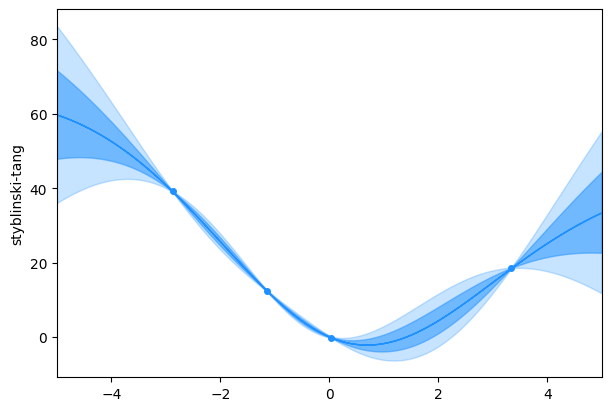

In [6]:
# what are the points?

agent.plot_tasks()

Note that the value of the fitness is the negative value of the function: we always want to maximize the fitness of the tasks.

An important concept in Bayesian optimization is the acquisition function, which is how the agent decides where to sample next. Under the hood, the agent will see what inputs maximize the acquisition function to make its decision.

We can see what the agent is thinking by asking it to plot a few different acquisition functions in its current state.

In [7]:
agent.acq_func_info

QUASI-RANDOM (identifiers: ['qr', 'quasi-random'])
-> Sobol-sampled quasi-random points.

EXPECTED MEAN (identifiers: ['em', 'expected_mean'])
-> The expected value at each input.

EXPECTED IMPROVEMENT (identifiers: ['ei', 'expected_improvement'])
-> The expected value of max(f(x) - \nu, 0), where \nu is the current maximum.

PROBABILITY OF IMPROVEMENT (identifiers: ['pi', 'probability_of_improvement'])
-> The probability that this input improves on the current maximum.

UPPER CONFIDENCE BOUND (identifiers: ['ucb', 'upper_confidence_bound'])
-> The expected value, plus some multiple of the uncertainty (typically \mu + 2\sigma).


/usr/share/miniconda3/envs/bloptools-py3.10/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


/usr/share/miniconda3/envs/bloptools-py3.10/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


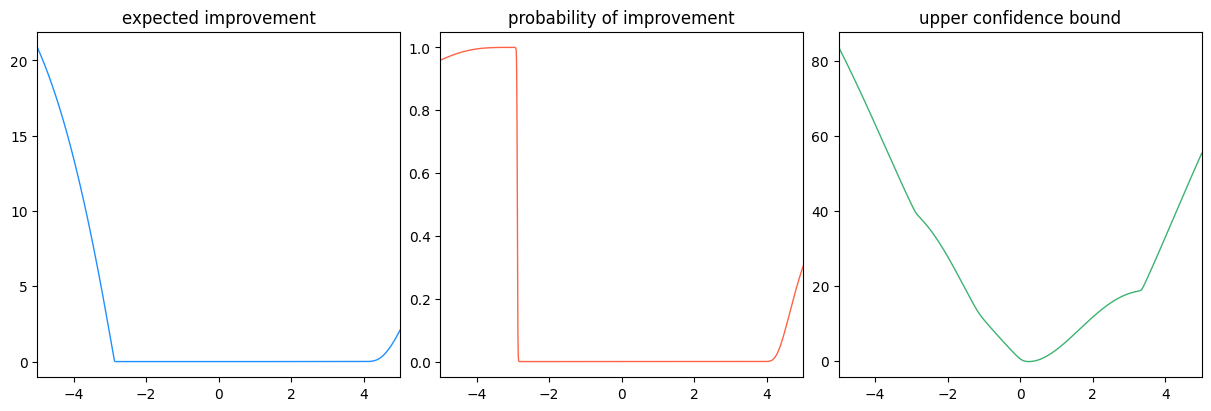

In [8]:
agent.plot_acquisition(acq_funcs=["ei", "pi", "ucb"])

Let's tell the agent to learn a little bit more. We just have to tell it what acquisition function to use (by passing a `strategy`) and how many iterations we'd like it to perform (by passing `n_iter`).



Transient Scan ID: 2     Time: 2023-08-11 05:55:18
Persistent Unique Scan ID: '76048739-56f6-4162-9d4b-89d9a8d92972'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |          x |
+-----------+------------+------------+
|         1 | 05:55:18.1 |     -5.000 |
+-----------+------------+------------+
generator list_scan ['76048739'] (scan num: 2)







Transient Scan ID: 3     Time: 2023-08-11 05:55:18
Persistent Unique Scan ID: 'fcd4cb86-cfa9-42ff-ba34-0c94022af19b'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |          x |
+-----------+------------+------------+
|         1 | 05:55:18.6 |      5.000 |
+-----------+------------+------------+
generator list_scan ['fcd4cb86'] (scan num: 3)







Transient Scan ID: 4     Time: 2023-08-11 05:55:19
Persistent Unique Scan ID: '3c8b4d3a-99dc-47a0-907d-b23657fe694b'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |          x |
+-----------+------------+------------+
|         1 | 05:55:19.3 |      2.193 |
+-----------+------------+------------+
generator list_scan ['3c8b4d3a'] (scan num: 4)







Transient Scan ID: 5     Time: 2023-08-11 05:55:20
Persistent Unique Scan ID: '3c35b41f-d820-4a8b-95aa-8dbb157e0527'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |          x |
+-----------+------------+------------+
|         1 | 05:55:20.2 |     -2.462 |
+-----------+------------+------------+
generator list_scan ['3c35b41f'] (scan num: 5)





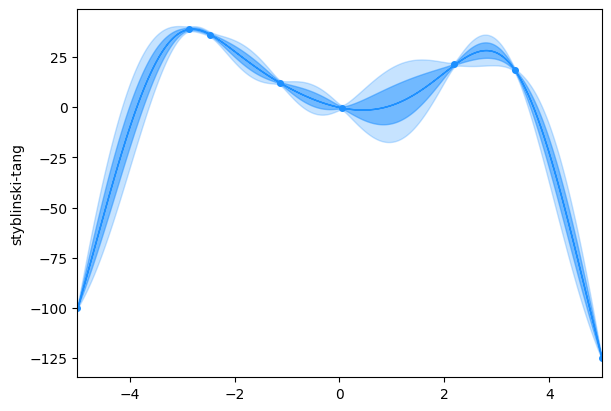

In [9]:
RE(agent.learn("ei", n_iter=4))
agent.plot_tasks()